In [6]:
import mne
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import re
from datetime import datetime
import utils
from dotenv import load_dotenv
import os
import importlib
importlib.reload(utils)

%matplotlib widget

load_dotenv()

epilepsy_filepath = os.getenv('EPILEPSY')
healthy_filepath = os.getenv('HEALTHY')
datasets_filepath = os.getenv("DATASETS")
epilepsy = Path(rf"{epilepsy_filepath}")
healthy = Path(rf"{healthy_filepath}")
datasets = Path(rf"{datasets_filepath}")

electrode_subset = []

Reading D:\Datasets\resting-state-eeg\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesclosed_eeg.fdt
Reading 0 ... 149999  =      0.000 ...   299.998 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, AF7, Fz, F1, F3, F5, F7, FC1, FC3, FC5, FT7, Cz, C1, ...
 chs: 61 EEG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 500.0 Hz
>

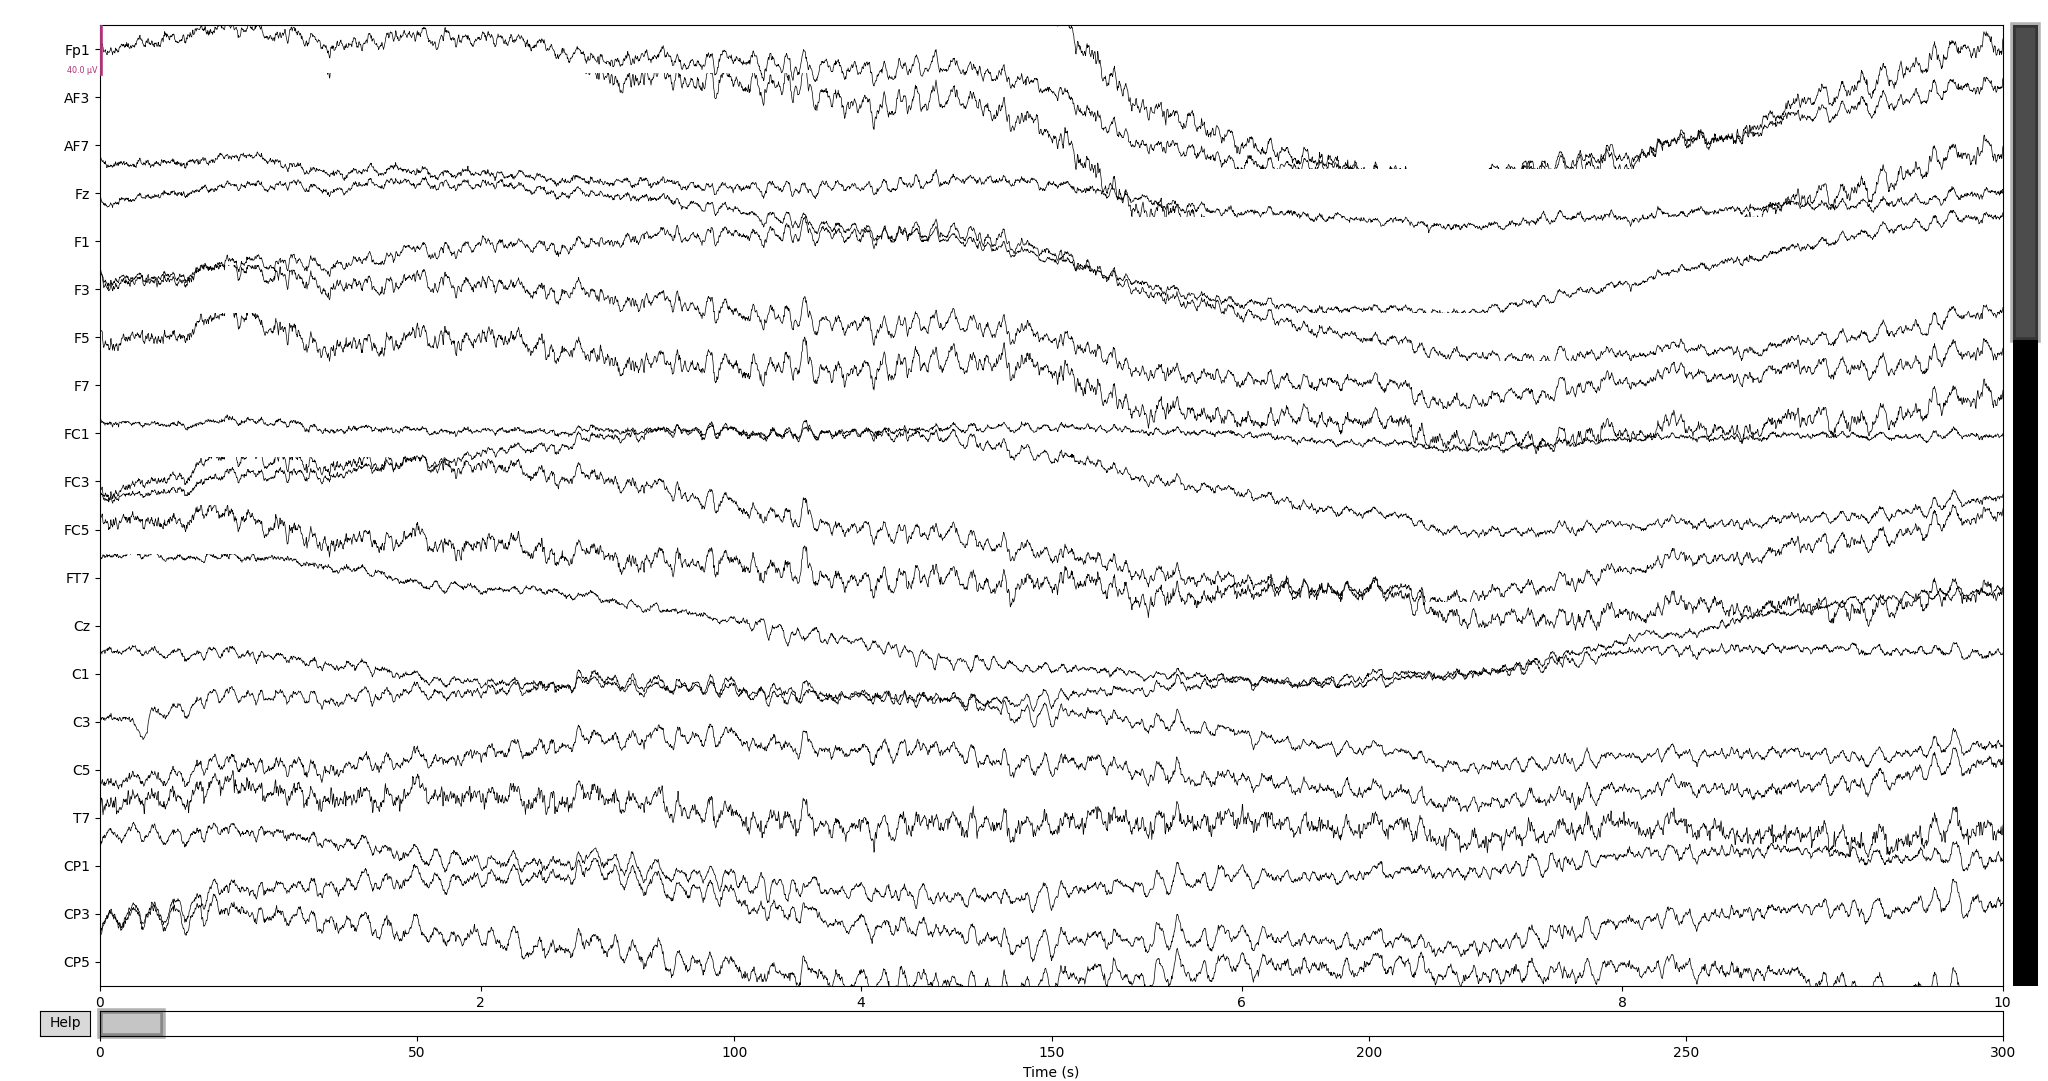

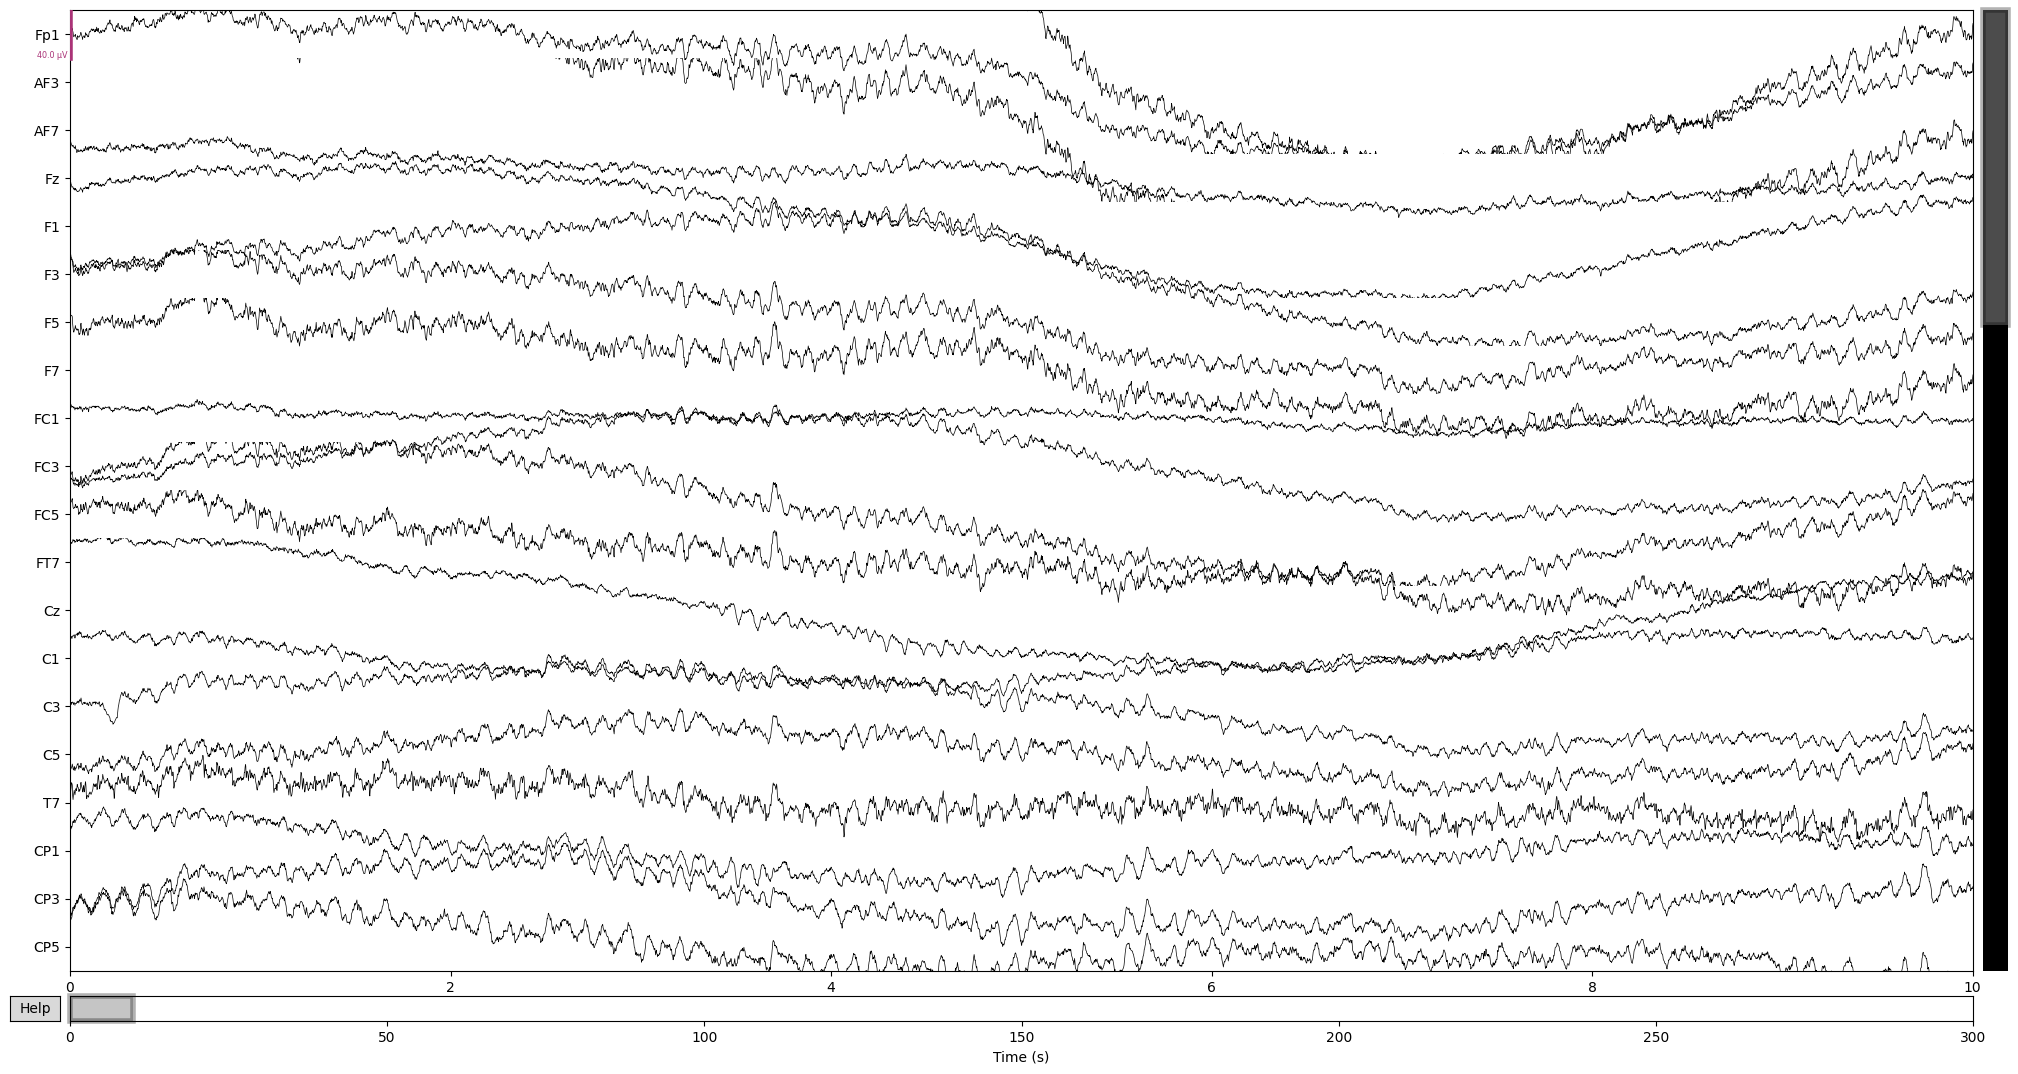

In [7]:
subj = Path(healthy, "sub-01")
session = Path(subj, "ses-1", "eeg")
h_edf = mne.io.read_raw_eeglab(
    Path(session, "sub-01_ses-1_task-eyesclosed_eeg.set"),
    preload=True
)
h_edf.set_montage("standard_1020", on_missing="warn")
display(h_edf.info)
# display(h_edf.ch_names)
h_edf.plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edg

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, C3, O1, Cp5, Fp2, C4, O2, Cp6
 chs: 8 EEG
 custom_ref_applied: False
 dig: 9 items (3 Cardinal, 6 EEG)
 highpass: 1.6 Hz
 lowpass: 30.0 Hz
 meas_date: 2016-01-01 19:39:33 UTC
 nchan: 8
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>

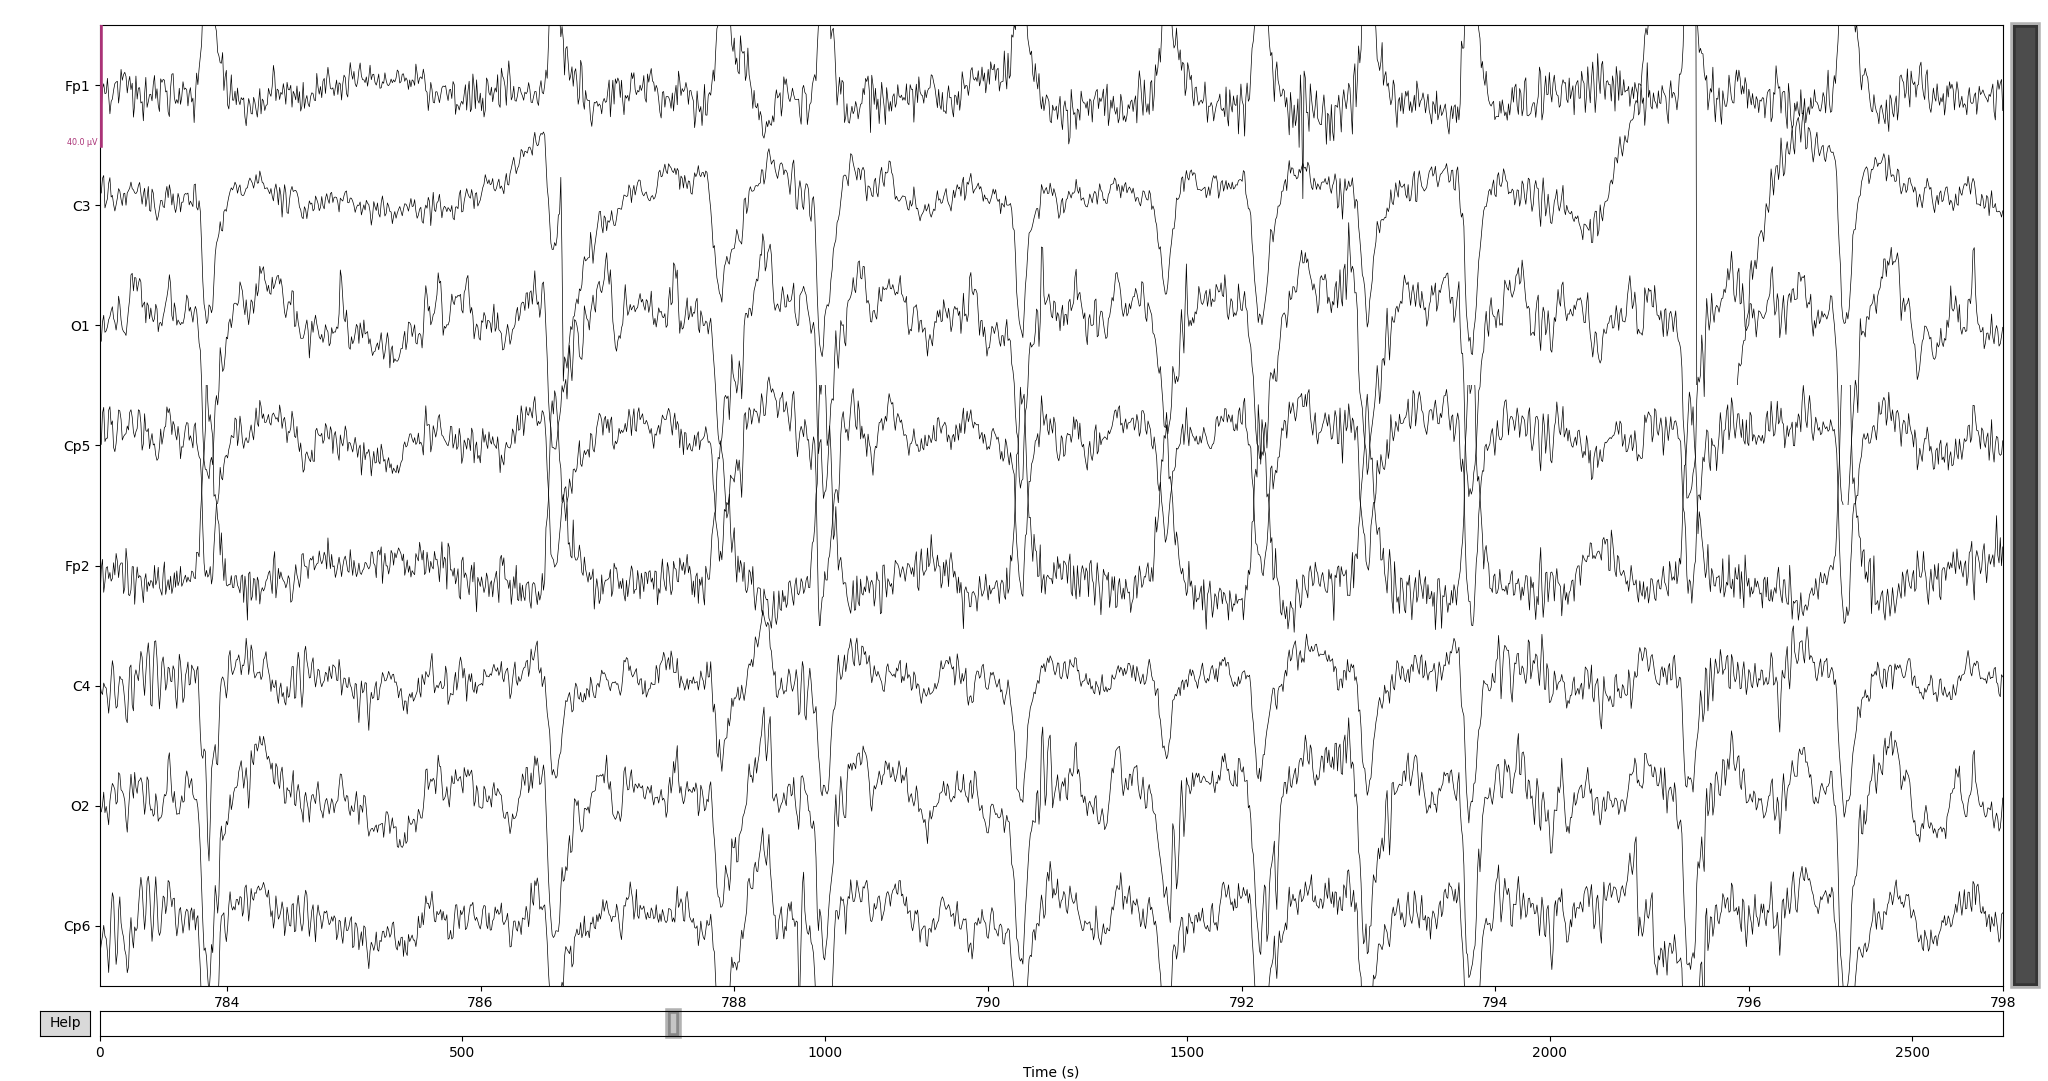

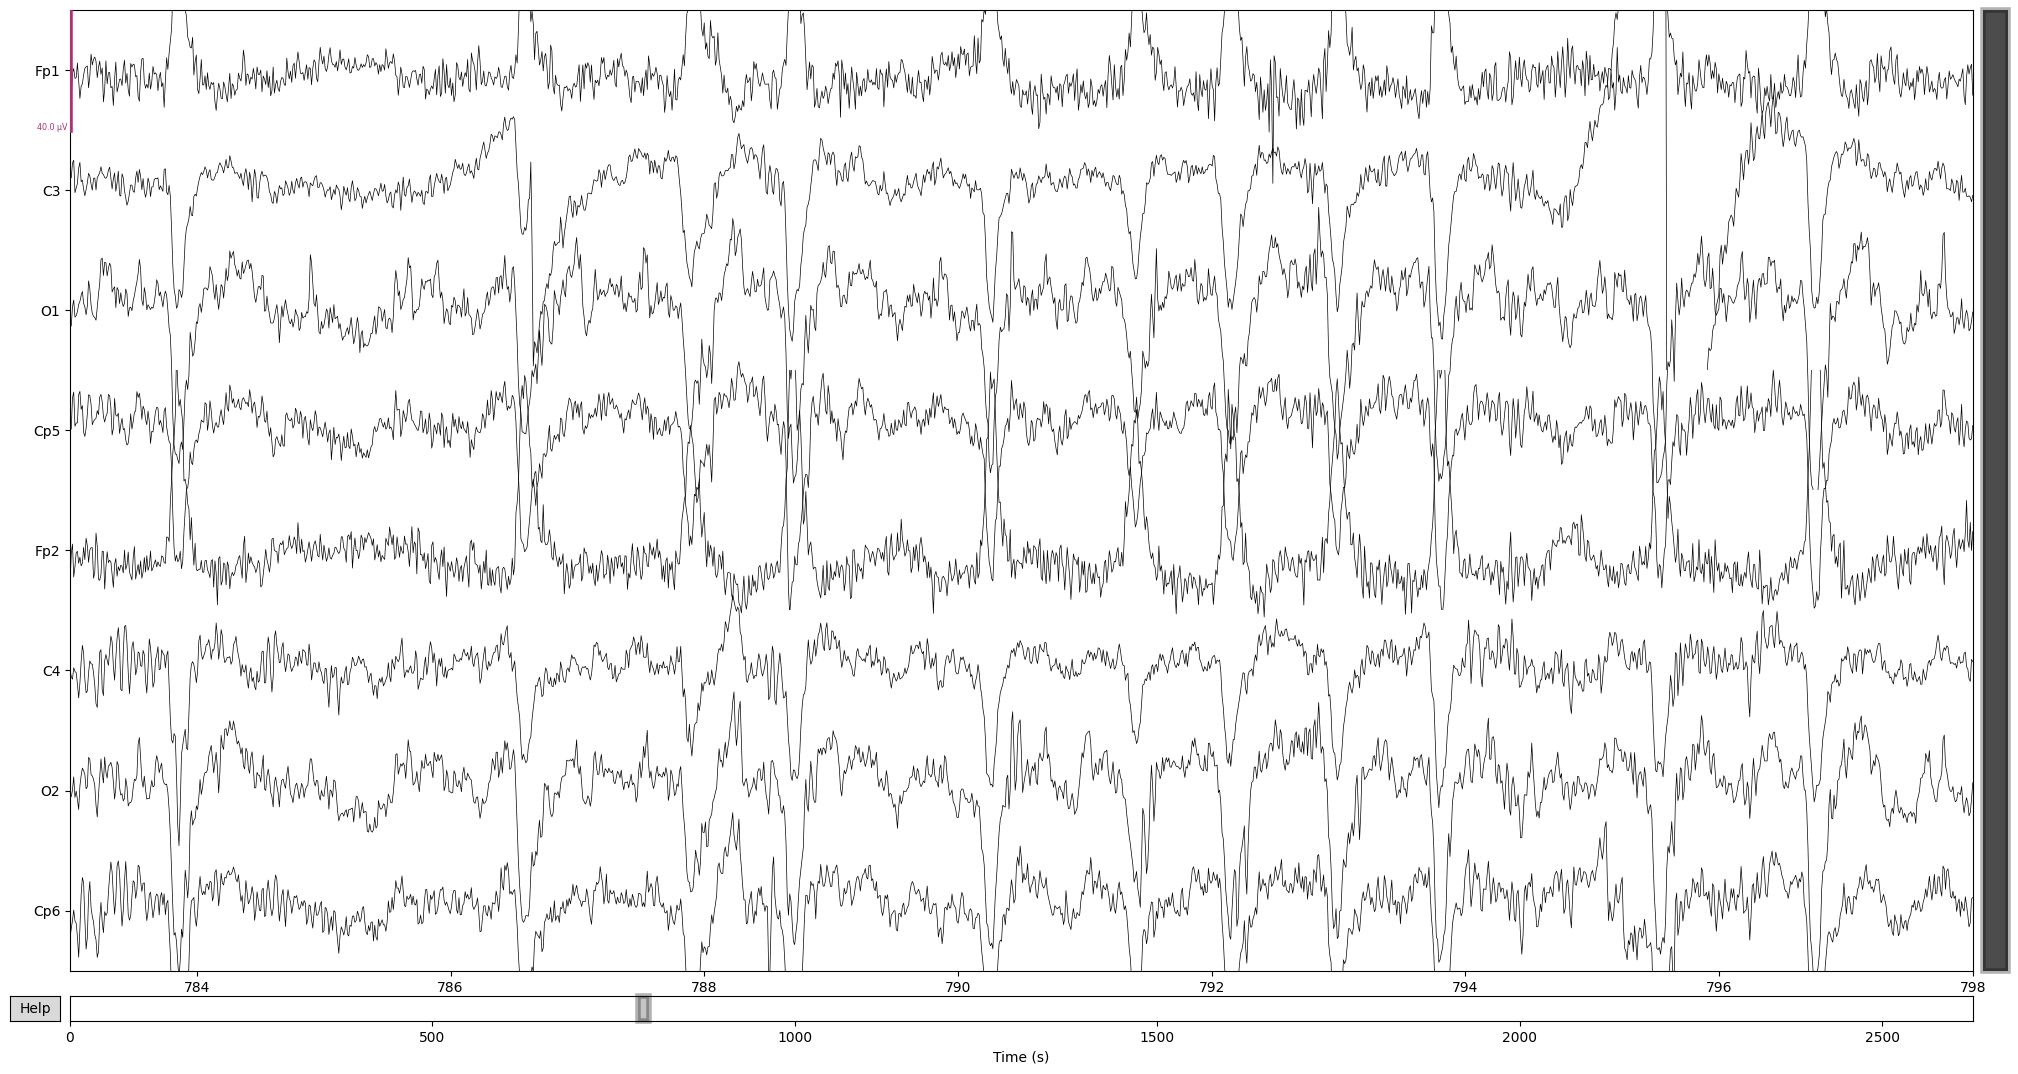

In [8]:
subj = Path(epilepsy, "PN00")
ep_edf = mne.io.read_raw_edf(
    Path(subj, "PN00-1.edf"),
    preload=True,
    infer_types=True,
    # exclude=["EKG EKG", "SPO2", "HR", "1", "2", "MK"],
    # exclude=["SPO2", "HR", "1", "2", "MK"],
    include=['Fp1', 'Fp2', 'Cp5', 'Cp6', 'C3', 'C4', 'O1', 'O2'],
    verbose=False,
)

ep_edf = ep_edf.copy().filter(l_freq=1, h_freq=40).notch_filter(60)
# ep_edf = mne.set_bipolar_reference(
#     ep_edf,
#     anode=['Fp1', 'F3', 'C3', 'P3', 'F4', 'C4', 'P4', 'Fp1', 'F7', 'T3', 'T5', 'F8', 'Fz', 'Cz'],    
#     cathode=['F3', 'C3', 'P3', 'O1', 'C4', 'P4', 'O2', 'F7', 'T3', 'T5', 'O1', 'T4', 'Cz', 'Pz'],
# )
ep_edf.set_montage("standard_1020", on_missing="ignore")
display(ep_edf.info)
# display(ep_edf.ch_names)
# ep_edf = ep_edf.crop(tmin=6830, tmax=6880)
ep_edf.plot(start=783, duration=15)

In [9]:
importlib.reload(utils)
subj = Path(epilepsy, "PN00")
file_path = Path(subj, "Seizures-list-PN00.txt")
file_map = utils.read_seizure_times(file_path)
print(file_map)

defaultdict(<class 'list'>, {'PN00-1.edf': [(1143.0, 1213.0)], 'PN00-2.edf': [(1220.0, 1274.0)], 'PN00-3.edf': [(765.0, 4425.0)], 'PN00-4.edf': [(1006.0, 1080.0)], 'PN00-5.edf': [(904.0, 971.0)]})


In [10]:
# get eeg from -6min to -1 min range


cropped_ep_edf_map = {}  # Dictionary to store the mapping of cropped EDF files to subjects
output_folder = datasets # Folder to save the cropped EDF files
output_folder.mkdir(exist_ok=True)  # Create the output folder if it doesn't exist

i = 1
for pn_folder in epilepsy.glob("PN*"):
    if pn_folder.is_dir():
        print(f"processing folder: {pn_folder.name}")

        subj = Path(epilepsy, pn_folder.name)
        seizure_list_path = Path(subj, f"Seizures-list-{pn_folder.name}.txt")
        seizure_times_map = utils.read_seizure_times(seizure_list_path)
        print(seizure_times_map)
        # iterate through .edf files
        for idx, edf_file in enumerate(pn_folder.glob("*.edf")):
            print(f"  Found EDF file: {edf_file.name}")

            start_end_pairs_list = seizure_times_map.get(edf_file.name, [])

            for start, end in start_end_pairs_list:
                epileform_start = start - 360
                epileform_end = start - 60

                print(f"    File: {edf_file.name} -> start: {epileform_start} | end: {epileform_end}")

                ep_edf = mne.io.read_raw_edf(
                    Path(subj, edf_file.name),
                    preload=True,
                    infer_types=True,
                    # exclude=["EKG EKG", "SPO2", "HR", "1", "2", "MK"],
                    # exclude=["SPO2", "HR", "1", "2", "MK"],
                    include=['Fp1', 'Fp2', 'Cp5', 'Cp6', 'C3', 'C4', 'O1', 'O2'],
                    verbose=False,
                )

                ep_edf = ep_edf.filter(l_freq=1, h_freq=40, verbose=False).notch_filter(60, verbose=False)
                ep_edf.set_montage("standard_1020", on_missing="ignore")
                ep_edf = ep_edf.crop(tmin=epileform_start, tmax=epileform_end)

                cropped_filename = f"cropped_ep{i}.fif"
                output_path = output_folder / cropped_filename
                
                ep_edf.save(output_path, overwrite=True, verbose=False)
                cropped_ep_edf_map[cropped_filename] = subj.name

                i += 1
                # print(ep_edf.times)






# ep_edf = ep_edf.copy().filter(l_freq=1, h_freq=40).notch_filter(60)
# # ep_edf = mne.set_bipolar_reference(
# #     ep_edf,
# #     anode=['Fp1', 'F3', 'C3', 'P3', 'F4', 'C4', 'P4', 'Fp1', 'F7', 'T3', 'T5', 'F8', 'Fz', 'Cz'],    
# #     cathode=['F3', 'C3', 'P3', 'O1', 'C4', 'P4', 'O2', 'F7', 'T3', 'T5', 'O1', 'T4', 'Cz', 'Pz'],
# # )
# ep_edf.set_montage("standard_1020", on_missing="ignore")
# display(ep_edf.info)
# # display(ep_edf.ch_names)
# ep_edf = ep_edf.crop(tmin=6830, tmax=6880)
# ep_edf.plot(duration=15)


processing folder: PN00
defaultdict(<class 'list'>, {'PN00-1.edf': [(1143.0, 1213.0)], 'PN00-2.edf': [(1220.0, 1274.0)], 'PN00-3.edf': [(765.0, 4425.0)], 'PN00-4.edf': [(1006.0, 1080.0)], 'PN00-5.edf': [(904.0, 971.0)]})
  Found EDF file: PN00-1.edf
    File: PN00-1.edf -> start: 783.0 | end: 1083.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN00-2.edf
    File: PN00-2.edf -> start: 860.0 | end: 1160.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN00-3.edf
    File: PN00-3.edf -> start: 405.0 | end: 705.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN00-4.edf
    File: PN00-4.edf -> start: 646.0 | end: 946.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN00-5.edf
    File: PN00-5.edf -> start: 544.0 | end: 844.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN01
defaultdict(<class 'list'>, {'PN01-1.edf': [(10218.0, 10272.0), (46353.0, 46427.0)]})
  Found EDF file: PN01-1.edf
    File: PN01-1.edf -> start: 9858.0 | end: 10158.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


    File: PN01-1.edf -> start: 45993.0 | end: 46293.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN03
defaultdict(<class 'list'>, {'PN03-1.edf': [(38673.0, 38784.0)], 'PN03-2.edf': [(34921.0, 35054.0)]})
  Found EDF file: PN03-1.edf
    File: PN03-1.edf -> start: 38313.0 | end: 38613.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN03-2.edf
    File: PN03-2.edf -> start: 34561.0 | end: 34861.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN05
defaultdict(<class 'list'>, {'PN05-2.edf': [(7163.0, 7198.0)], 'PN05-3.edf': [(6836.0, 6866.0)], 'PN05-4.edf': [(3608.0, 3647.0)]})
  Found EDF file: PN05-2.edf
    File: PN05-2.edf -> start: 6803.0 | end: 7103.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN05-3.edf
    File: PN05-3.edf -> start: 6476.0 | end: 6776.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN05-4.edf
    File: PN05-4.edf -> start: 3248.0 | end: 3548.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN06
defaultdict(<class 'list'>, {'PN06-1.edf': [(5583.0, 5647.0)], 'PN06-2.edf': [(8860.0, 8929.0)], 'PN06-3.edf': [(6275.0, 6317.0)], 'PN06-4.edf': [(5939.0, 6002.0)], 'PN06-5.edf': [(4783.0, 4827.0)]})
  Found EDF file: PN06-1.edf
    File: PN06-1.edf -> start: 5223.0 | end: 5523.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN06-2.edf
    File: PN06-2.edf -> start: 8500.0 | end: 8800.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN06-3.edf
    File: PN06-3.edf -> start: 5915.0 | end: 6215.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN06-4.edf
    File: PN06-4.edf -> start: 5579.0 | end: 5879.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN06-5.edf
    File: PN06-5.edf -> start: 4423.0 | end: 4723.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN07
defaultdict(<class 'list'>, {'PN07-1.edf': [(22059.0, 22121.0)]})
  Found EDF file: PN07-1.edf
    File: PN07-1.edf -> start: 21699.0 | end: 21999.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN09
defaultdict(<class 'list'>, {'PN09-1.edf': [(7249.0, 7329.0)], 'PN09-2.edf': [(7127.0, 7186.0)], 'PN09-3.edf': [(7221.0, 7285.0)]})
  Found EDF file: PN09-1.edf
    File: PN09-1.edf -> start: 6889.0 | end: 7189.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN09-2.edf
    File: PN09-2.edf -> start: 6767.0 | end: 7067.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep20.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN09-3.edf
    File: PN09-3.edf -> start: 6861.0 | end: 7161.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN10
defaultdict(<class 'list'>, {'PN10-1.edf': [(7545.0, 7614.0)], 'PN10-2.edf': [(7798.0, 7849.0)], 'PN10-3.edf': [(7835.0, 7904.0)], 'PN10-4.5.6.edf': [(2309.0, 2314.0), (6544.0, 6563.0), (11225.0, 11282.0)], 'PN10-7.8.9.edf': [(2748.0, 2796.0), (5459.0, 5477.0), (12923.0, 12938.0)], 'PN10-10.edf': [(7977.0, 7991.0)]})
  Found EDF file: PN10-1.edf
    File: PN10-1.edf -> start: 7185.0 | end: 7485.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep22.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN10-10.edf
    File: PN10-10.edf -> start: 7617.0 | end: 7917.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep23.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN10-2.edf
    File: PN10-2.edf -> start: 7438.0 | end: 7738.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN10-3.edf
    File: PN10-3.edf -> start: 7475.0 | end: 7775.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN10-4.5.6.edf
    File: PN10-4.5.6.edf -> start: 1949.0 | end: 2249.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep26.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


    File: PN10-4.5.6.edf -> start: 6184.0 | end: 6484.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


    File: PN10-4.5.6.edf -> start: 10865.0 | end: 11165.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN10-7.8.9.edf
    File: PN10-7.8.9.edf -> start: 2388.0 | end: 2688.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


    File: PN10-7.8.9.edf -> start: 5099.0 | end: 5399.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


    File: PN10-7.8.9.edf -> start: 12563.0 | end: 12863.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN11
defaultdict(<class 'list'>, {'PN11-1.edf': [(7554.0, 7609.0)]})
  Found EDF file: PN11-1.edf
    File: PN11-1.edf -> start: 7194.0 | end: 7494.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep32.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN12
defaultdict(<class 'list'>, {'PN12-1.2.edf': [(1312.0, 1375.0), (9570.0, 9638.0)], 'PN12-3.edf': [(772.0, 868.0)], 'PN12-4.edf': [(9812.0, 9875.0)]})
  Found EDF file: PN12-1.2.edf
    File: PN12-1.2.edf -> start: 952.0 | end: 1252.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep33.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


    File: PN12-1.2.edf -> start: 9210.0 | end: 9510.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep34.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN12-3.edf
    File: PN12-3.edf -> start: 412.0 | end: 712.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN12-4.edf
    File: PN12-4.edf -> start: 9452.0 | end: 9752.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep36.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN13
defaultdict(<class 'list'>, {'PN13-1.edf': [(7062.0, 7110.0)], 'PN13-2.edf': [(7249.0, 7314.0)], 'PN13-3.edf': [(7553.0, 7704.0)]})
  Found EDF file: PN13-1.edf
    File: PN13-1.edf -> start: 6702.0 | end: 7002.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN13-2.edf
    File: PN13-2.edf -> start: 6889.0 | end: 7189.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN13-3.edf
    File: PN13-3.edf -> start: 7193.0 | end: 7493.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN14
defaultdict(<class 'list'>, {'PN14-1.edf': [(7262.0, 7289.0)], 'PN14-2.edf': [(7479.0, 7491.0)], 'PN14-3.edf': [(17540.0, 17581.0)], 'PN14-4.edf': [(5463.0, 5546.0)]})
  Found EDF file: PN14-1.edf
    File: PN14-1.edf -> start: 6902.0 | end: 7202.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN14-2.edf
    File: PN14-2.edf -> start: 7119.0 | end: 7419.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep41.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN14-3.edf
    File: PN14-3.edf -> start: 17180.0 | end: 17480.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN14-4.edf
    File: PN14-4.edf -> start: 5103.0 | end: 5403.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep43.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN16
defaultdict(<class 'list'>, {'PN16-1.edf': [(7184.0, 7307.0)], 'PN16-2.edf': [(8574.0, 8681.0)]})
  Found EDF file: PN16-1.edf
    File: PN16-1.edf -> start: 6824.0 | end: 7124.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep44.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN16-2.edf
    File: PN16-2.edf -> start: 8214.0 | end: 8514.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep45.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


processing folder: PN17
defaultdict(<class 'list'>, {'PN17-1.edf': [(8420.0, 8490.0)], 'PN17-2.edf': [(7731.0, 7814.0)]})
  Found EDF file: PN17-1.edf
    File: PN17-1.edf -> start: 8060.0 | end: 8360.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep46.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


  Found EDF file: PN17-2.edf
    File: PN17-2.edf -> start: 7371.0 | end: 7671.0


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3199215203.py:46: RuntimeWarning: This filename (D:\Datasets\cropped_ep47.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ep_edf.save(output_path, overwrite=True, verbose=False)


In [11]:
print(cropped_ep_edf_map)

{'cropped_ep1.fif': 'PN00', 'cropped_ep2.fif': 'PN00', 'cropped_ep3.fif': 'PN00', 'cropped_ep4.fif': 'PN00', 'cropped_ep5.fif': 'PN00', 'cropped_ep6.fif': 'PN01', 'cropped_ep7.fif': 'PN01', 'cropped_ep8.fif': 'PN03', 'cropped_ep9.fif': 'PN03', 'cropped_ep10.fif': 'PN05', 'cropped_ep11.fif': 'PN05', 'cropped_ep12.fif': 'PN05', 'cropped_ep13.fif': 'PN06', 'cropped_ep14.fif': 'PN06', 'cropped_ep15.fif': 'PN06', 'cropped_ep16.fif': 'PN06', 'cropped_ep17.fif': 'PN06', 'cropped_ep18.fif': 'PN07', 'cropped_ep19.fif': 'PN09', 'cropped_ep20.fif': 'PN09', 'cropped_ep21.fif': 'PN09', 'cropped_ep22.fif': 'PN10', 'cropped_ep23.fif': 'PN10', 'cropped_ep24.fif': 'PN10', 'cropped_ep25.fif': 'PN10', 'cropped_ep26.fif': 'PN10', 'cropped_ep27.fif': 'PN10', 'cropped_ep28.fif': 'PN10', 'cropped_ep29.fif': 'PN10', 'cropped_ep30.fif': 'PN10', 'cropped_ep31.fif': 'PN10', 'cropped_ep32.fif': 'PN11', 'cropped_ep33.fif': 'PN12', 'cropped_ep34.fif': 'PN12', 'cropped_ep35.fif': 'PN12', 'cropped_ep36.fif': 'PN12', 

Opening raw data file D:\Datasets\cropped_ep1.fif...


    Range : 400896 ... 554496 =    783.000 ...  1083.000 secs
Ready.
Reading 0 ... 153600  =      0.000 ...   300.000 secs...


C:\Users\jason\AppData\Local\Temp\ipykernel_34200\3881298669.py:1: RuntimeWarning: This filename (D:\Datasets\cropped_ep1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cropped_ep_edf = mne.io.read_raw_fif(Path(output_folder, "cropped_ep1.fif"), preload=True)


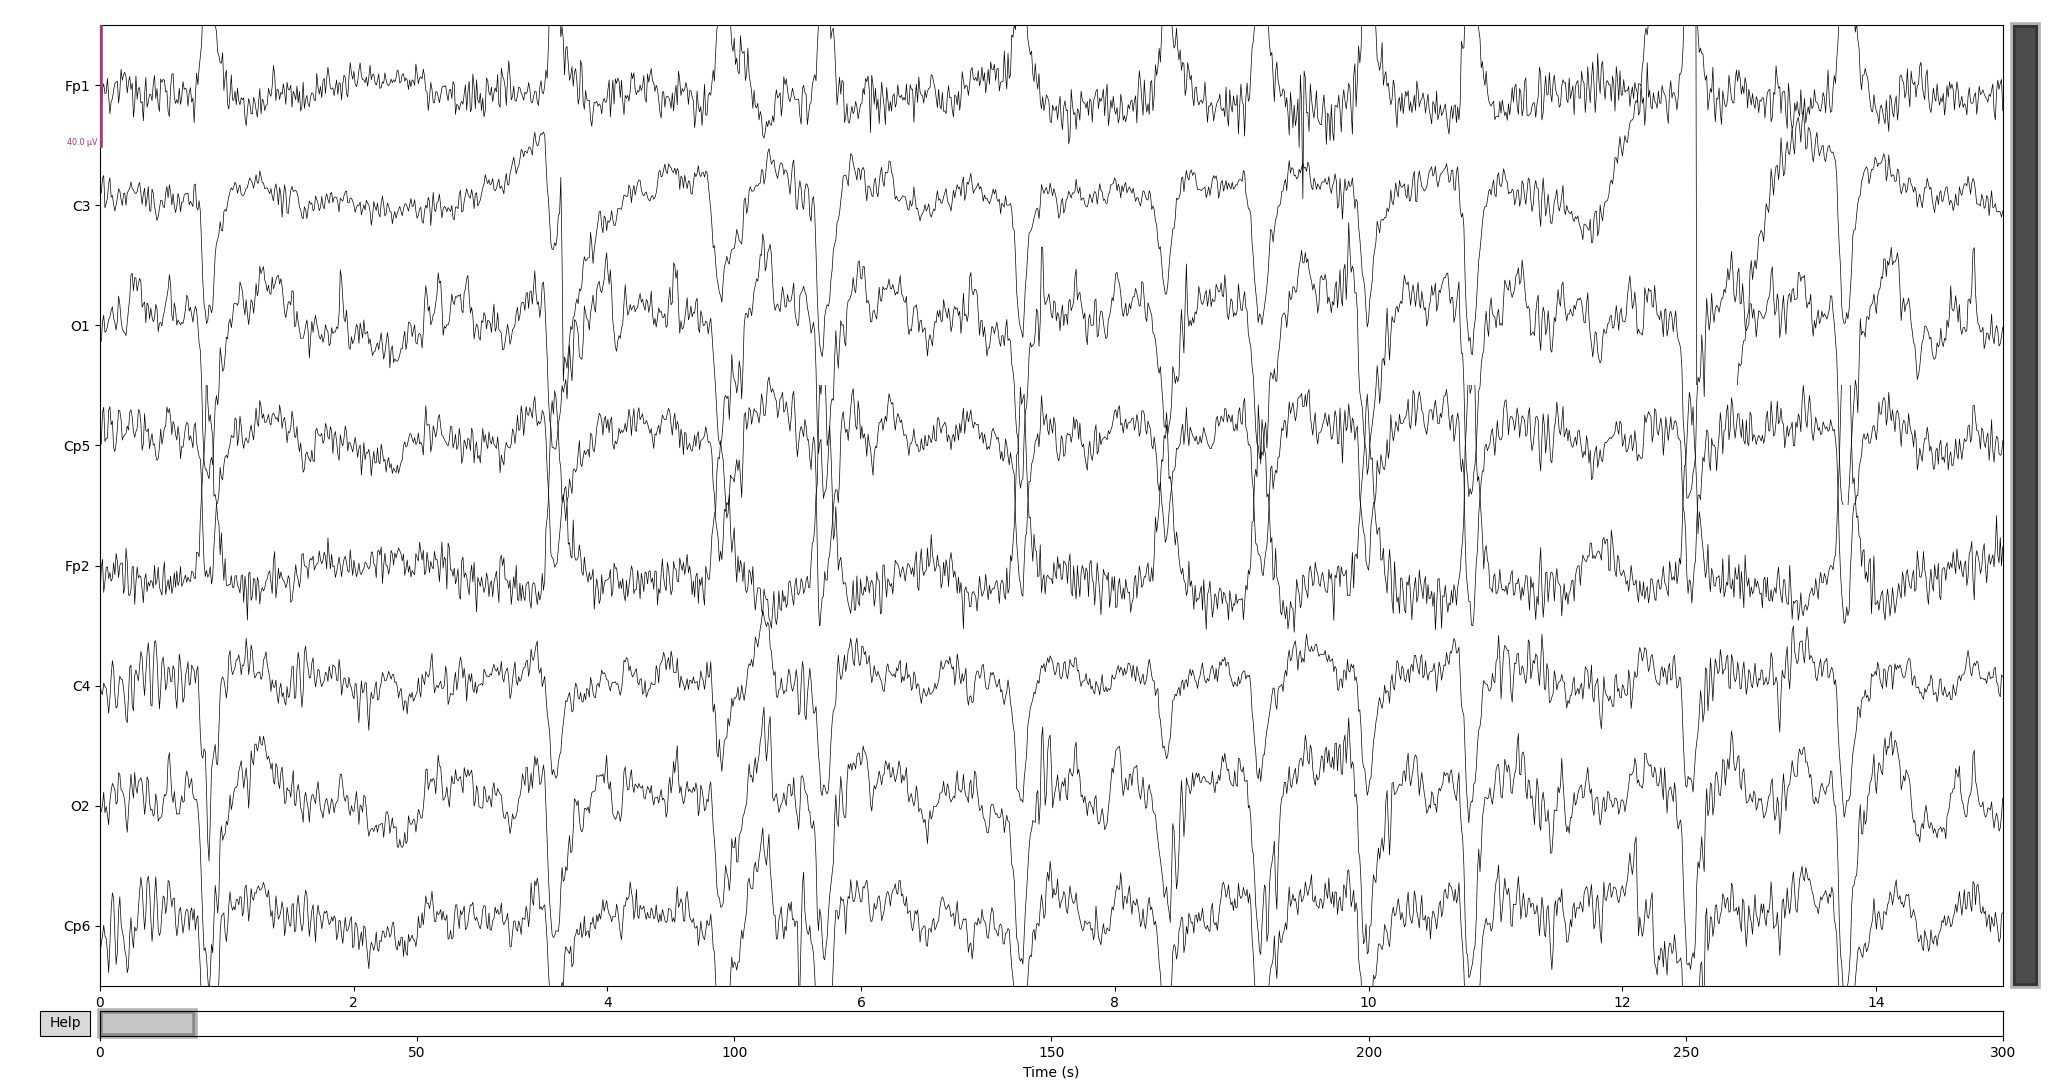

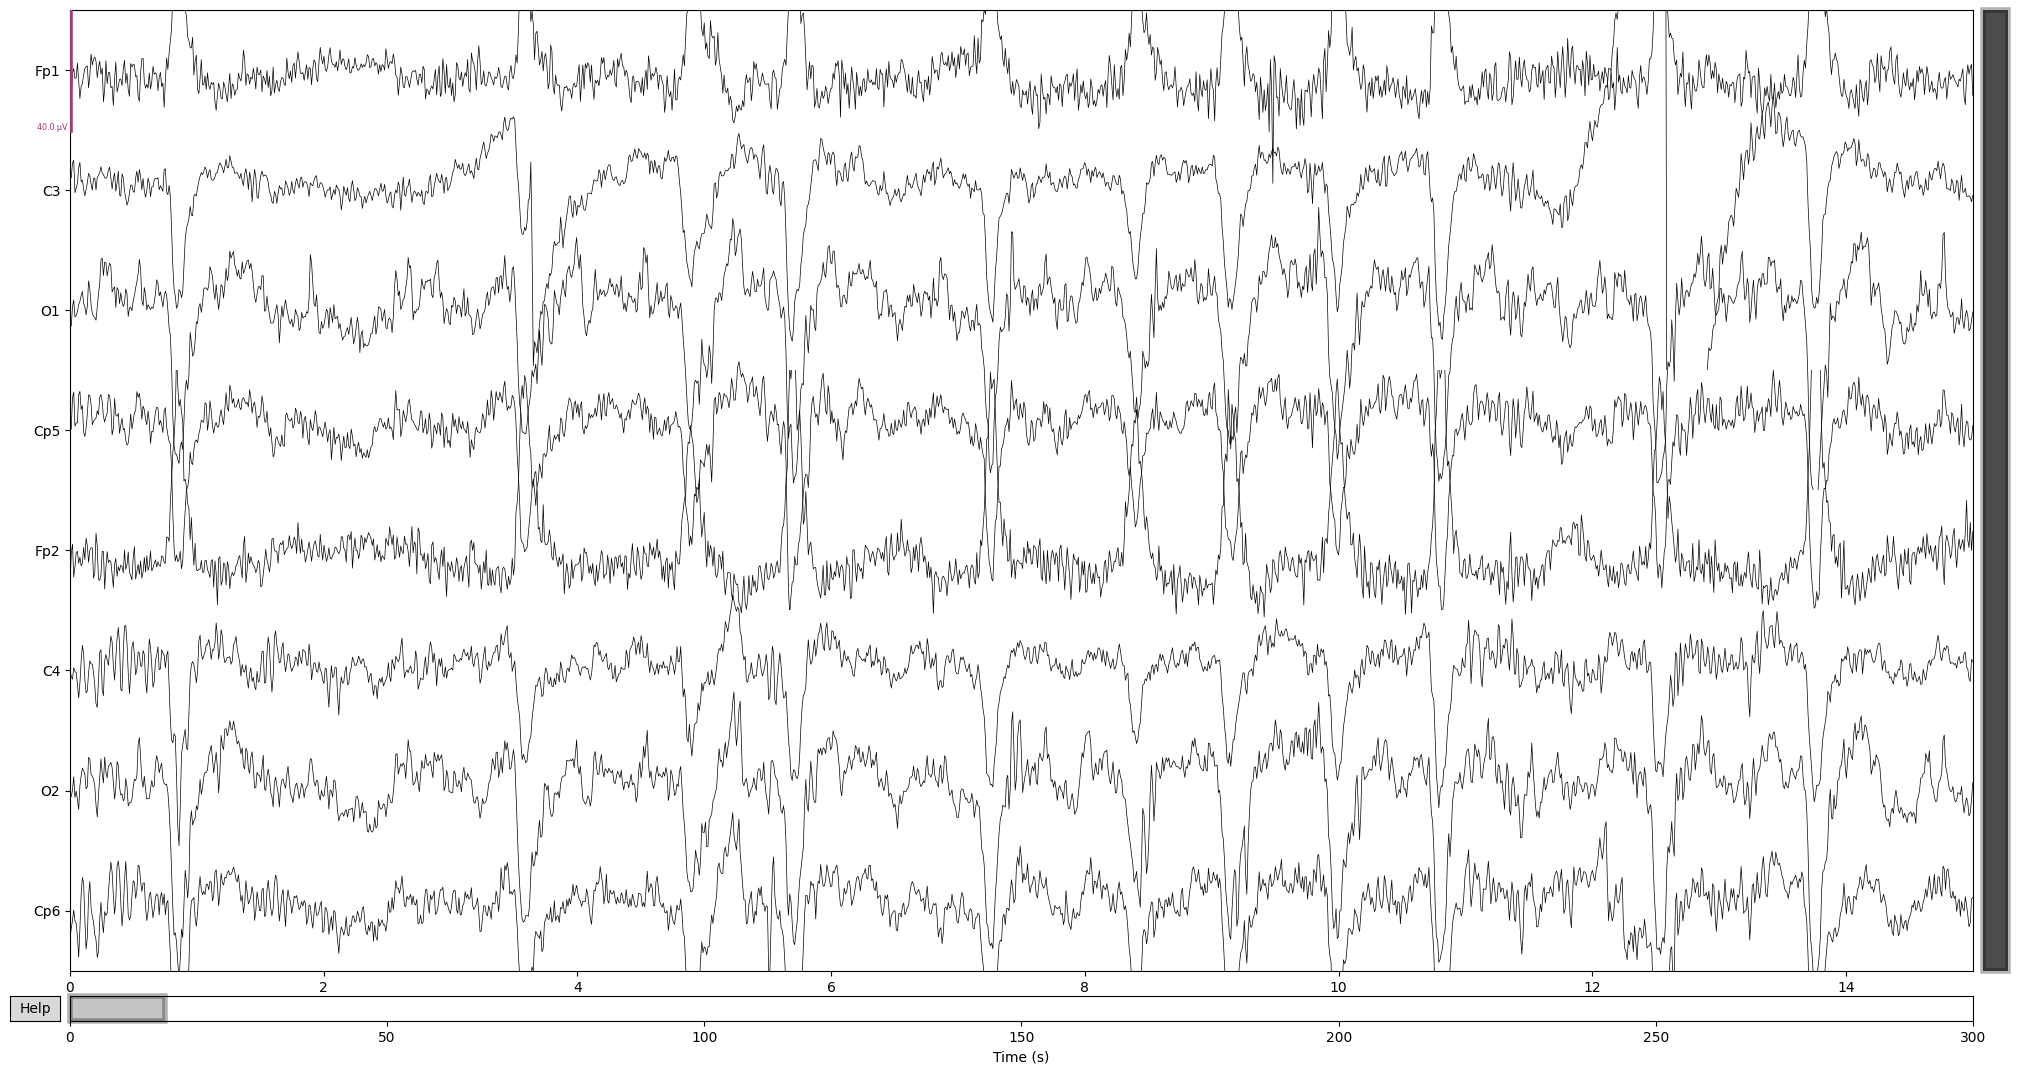

In [12]:


cropped_ep_edf = mne.io.read_raw_fif(Path(output_folder, "cropped_ep1.fif"), preload=True)

cropped_ep_edf.plot(duration=15)

In [13]:
for cropped_ep in output_folder.glob("*"):
    pass